# Uplift modeling

In [25]:
import pandas
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype
import numpy as np
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from datetime import datetime
from collections import OrderedDict
from operator import itemgetter   
from matplotlib import pyplot as plt
import seaborn as sns
import eli5

In [37]:
def uplift_fit_predict(model, X_train, treatment_train, target_train, X_test, return_model=True):
    """
    Реализация простого способа построения uplift-модели.
    
    Обучаем два бинарных классификатора, которые оценивают вероятность target для клиента:
    1. с которым была произведена коммуникация (treatment=1)
    2. с которым не было коммуникации (treatment=0)
    
    В качестве оценки uplift для нового клиента берется разница оценок вероятностей:
    Predicted Uplift = P(target|treatment=1) - P(target|treatment=0)
    """
    X_treatment, y_treatment = X_train[treatment_train == 1, :], target_train[treatment_train == 1]
    X_control, y_control = X_train[treatment_train == 0, :], target_train[treatment_train == 0]
    model_treatment = clone(model).fit(X_treatment, y_treatment)
    model_control = clone(model).fit(X_control, y_control)
    predict_treatment = model_treatment.predict_proba(X_test)[:, 1]
    predict_control = model_control.predict_proba(X_test)[:, 1]
    predict_uplift = predict_treatment - predict_control
    if return_model:
        return predict_uplift, model_treatment, model_control
    else:
        return predict_uplift

def pickle_model(model_tr, model_c):
    name_file_model_tr = 'LGBM_model_tr_%s.pkl' %now
    name_file_model_tr = 'LGBM_model_c_%s.pkl' %now
    joblib.dump(model_tr, name_file_model_tr) 
    joblib.dump(model_c, name_file_model_c) 

def uplift_score(prediction, treatment, target, rate=0.3):
    """
    Подсчет Uplift Score
    """
    order = np.argsort(-prediction)
    treatment_n = int((treatment == 1).sum() * rate)
    treatment_p = target[order][treatment[order] == 1][:treatment_n].mean()
    control_n = int((treatment == 0).sum() * rate)
    control_p = target[order][treatment[order] == 0][:control_n].mean()
    score = treatment_p - control_p
    return score

def group_analisys(df_features, model,print_score=True,save_model=True,make_sibmition=True,
            filename='submission',return_score=False):
    """
    Вывод скора, создание сабмитов, сохранение модели
    """
    now = str(datetime.now()).replace(' ','-')[:13]
    indices_train = df_train.index
    indices_test = df_test.index
    indices_learn, indices_valid = train_test_split(df_train.index, test_size=0.3, random_state=123)

    # Оценка качества на валидации
    if print_score:
        valid_uplift = uplift_fit_predict(
            model=model,
            X_train=df_features.loc[indices_learn, :].fillna(0).values,
            treatment_train=df_train.loc[indices_learn, 'treatment_flg'].values,
            target_train=df_train.loc[indices_learn, 'target'].values,
            X_test=df_features.loc[indices_valid, :].fillna(0).values,
            return_model=False
            )
        valid_score = uplift_score(valid_uplift,
            treatment=df_train.loc[indices_valid, 'treatment_flg'].values,
            target=df_train.loc[indices_valid, 'target'].values,
            )
        print('Validation score:', valid_score)
        if return_score:
            return valid_score
    #
    if make_sibmition:
        test_uplift, model_treatment, model_control = uplift_fit_predict(
        model=model,
        X_train=df_features.loc[indices_train, :].fillna(0).values,
        treatment_train=df_train.loc[indices_train, 'treatment_flg'].values,
        target_train=df_train.loc[indices_train, 'target'].values,
        X_test=df_features.loc[indices_test, :].fillna(0).values,
        return_model=save_model
        )
        df_submission = pandas.DataFrame({'uplift': test_uplift}, index=df_test.index)
        name = filename + now + '.csv'
        df_submission.to_csv(name)
        print(f'File {name} is saved')
        if save_model:
            # Save the model as a pickle in a file 
            name_file_model_tr = 'LGBM_model_tr_%s.pkl' %now
            name_file_model_c = 'LGBM_model_c_%s.pkl' %now
            joblib.dump(model_treatment, name_file_model_tr) 
            joblib.dump(model_control, name_file_model_c)  
            print(f'Model {name_file_model_tr} is saved')
            print(f'Model {name_file_model_c} is saved')
# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
# Modified to support timestamp type, categorical type
# Modified to add option to use float16 or not. feather format does not support float16.

def reduce_mem_usage(df, use_float16=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            # skip datetime type or categorical type
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

def make_feats(group, index, logging=True):
    """
    Вспомагательный метод, для  генерации признаков
    """
#     funs = ['mean','max','min','std']
    funs = ['mean','max','min','std']
    ser = pandas.DataFrame(index=index)
    for f in funs:
        if logging:
            ser = ser.join(np.log(group.agg(f)).replace([np.inf, -np.inf], 0).fillna(0).astype(int), rsuffix=f'_{f}')
        else:
            ser = ser.join(group.agg(f).fillna(0).astype(int), rsuffix=f'_{f}')
    return ser

def print_cv(df, pars, params_values_check={}):
    """
    Обычная кросс-валидация
    """
    cv_res = {}
    for k, v in params_values_check.items():
        cv_res_small = {}
        for values_param in v:
            pars[k] = v
            model = LGBMClassifier(**pars)
            val_score = group_analisys(df,model=model,print_score=False,make_sibmition=False, 
                                       return_score=True)
            cv_res_small[v] = val_score
        cv_res[k] = cv_res_small
    print(cv_res)

# Чтение данных

In [3]:
df_clients = pandas.read_csv('data/clients.csv', index_col='client_id')
df_clients = reduce_mem_usage(df_clients)
df_train = pandas.read_csv('data/uplift_train.csv', index_col='client_id')
df_train = reduce_mem_usage(df_train)
df_test = pandas.read_csv('data/uplift_test.csv', index_col='client_id')
df_test = reduce_mem_usage(df_test)
df_products = pandas.read_csv('data/products.csv', index_col='product_id')
df_products = reduce_mem_usage(df_products)
df_purchases = pandas.read_csv('data/purchases.csv', nrows=200000)
df_purchases = reduce_mem_usage(df_purchases)

Memory usage of dataframe is 15.26 MB
Memory usage after optimization is: 33.04 MB
Decreased by -116.5%
Memory usage of dataframe is 4.58 MB
Memory usage after optimization is: 1.91 MB
Decreased by 58.3%
Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 1.53 MB
Decreased by 0.0%
Memory usage of dataframe is 3.61 MB
Memory usage after optimization is: 1.58 MB
Decreased by 56.3%
Memory usage of dataframe is 19.84 MB
Memory usage after optimization is: 12.84 MB
Decreased by 35.3%


### Небольшие выводы
- 'transaction_id' соотвествует единственная стоимость 'purchase_sum';
- 'transaction_id' привязана к магазину 'store_id'
- 'transaction_id' привязаны (соотвествуют) к regular_points_received и всем признакам с поинтами

# Извлечение признаков

In [4]:
df_clients['first_issue_unixtime'] = pandas.to_datetime(df_clients['first_issue_date']).astype(int)/10**9
df_clients['first_redeem_unixtime'] = pandas.to_datetime(df_clients['first_redeem_date']).astype(int)/10**9
df_features = pandas.DataFrame({
    'gender_M': (df_clients['gender'] == 'M').astype(int),
    'gender_F': (df_clients['gender'] == 'F').astype(int),
    'gender_U': (df_clients['gender'] == 'U').astype(int),
    'age': df_clients['age'],
    'first_issue_time': df_clients['first_issue_unixtime'],
    'first_redeem_time': df_clients['first_redeem_unixtime'],
    'issue_redeem_delay': df_clients['first_redeem_unixtime'] - df_clients['first_issue_unixtime'],
}).fillna(0)

# EDA

### Распределение кол-ва покупок клиентов
Имеет логнормальное распределение, можно логарифмировать данный признак

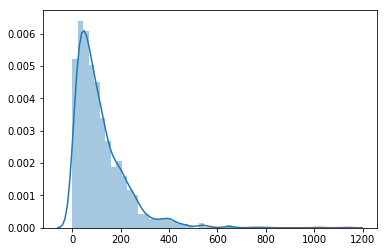

In [5]:
sns.distplot(list(df_purchases.groupby('client_id').size().values))

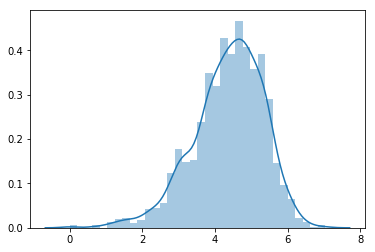

In [6]:
sns.distplot(np.log(df_purchases.groupby('client_id').size()))

In [7]:
# кол-во покупок
df_features = df_features.join(df_purchases.client_id.value_counts().rename('count_all_purschases'))
print("Add feature count_all_purschases")

#кол-во уникальных магазинов клиента
df_features = df_features.join(df_purchases.groupby(['client_id'])['store_id'].nunique(
    ).rename('count_all_stores'))
print("Add feature count_all_stores")

Add feature count_all_purschases
Add feature count_all_stores


### Распределение min purchase_sum
Для каждого клиента взять среднее по транзакциями (при соотвествии одному значению транзакции единственному значению признака, в данном случае "purchase_sum" - отсечение повторений) и вычислени минимальной суммы покупки клиента. 
Данный признак также можно логарифмировать.

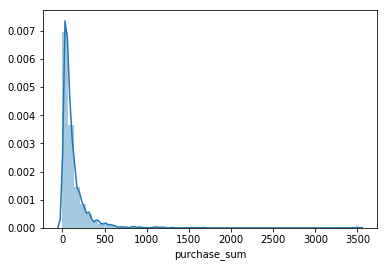

In [8]:
sns.distplot(df_purchases.groupby(['client_id','transaction_id']).purchase_sum.mean().groupby(
    'client_id').agg('min'))

/home/helga/anaconda3/envs/curr_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


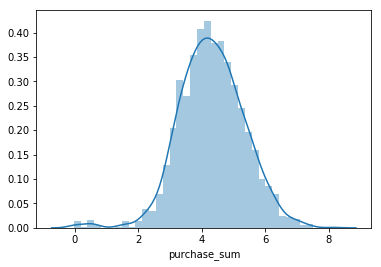

In [9]:
x = np.log(df_purchases.groupby(['client_id','transaction_id']).purchase_sum.mean().groupby(
    'client_id').agg('min'))
x[x == -np.inf] = 0
sns.distplot(x)

In [10]:
df_purchases.head()

,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red
0,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,9a80204f78,2.0,80.0,NaN
1,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,da89ebd374,1.0,65.0,NaN
2,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,0a95e1151d,1.0,24.0,NaN
3,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,4055b15e4a,2.0,50.0,NaN
4,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,a685f1916b,1.0,22.0,NaN


### Генерация признаков

In [11]:
funs = ['mean','max','min','std']

# средняя, max, min u std цена покупок
temp = df_purchases.groupby(['client_id','transaction_id']).purchase_sum.mean().rename('purch_sum_').groupby('client_id')
df_features = df_features.join(make_feats(temp,df_features.index))
print("Add feature purch_sum_ X4")

# среднее, max, min u std кол-во уникальных продуктов в разных магазинах
temp = df_purchases.groupby(['client_id','store_id'])['product_id'].nunique().rename('product_uni_').groupby('client_id')
df_features = df_features.join(make_feats(temp,df_features.index))
print("Add feature product_uni_ X4")

#среднее, max, min u std кол-во товаров  за 1 покупку (транзакцию)
temp = df_purchases.groupby(['client_id','transaction_id'])['product_quantity'].sum().rename('product_quant_').groupby(['client_id'])
df_features = df_features.join(make_feats(temp,df_features.index))
print("Add feature product_quant_ X4")

# среднее, max, min u std кол-во уникальных продуктов за транзакцию
temp = df_purchases.groupby(['client_id','transaction_id'])['product_id'].nunique().rename('uniq_prod_by_trunc_').groupby('client_id')
df_features = df_features.join(make_feats(temp,df_features.index))
print("Add feature uniq_prod_by_trunc_ X4")

temp = df_purchases.groupby(['client_id','transaction_id'])['trn_sum_from_iss'].mean().rename('trn_sum_from_iss_').groupby('client_id')
df_features = df_features.join(make_feats(temp,df_features.index))
print("Add feature trn_sum_from_iss_ X4")

temp = df_purchases.groupby(['client_id','transaction_id'])['trn_sum_from_red'].mean().rename('trn_sum_from_red_').groupby('client_id')
df_features = df_features.join(make_feats(temp,df_features.index))
print("Add feature trn_sum_from_red_ X4")

# для последнего месяца!!
last_month = df_purchases[df_purchases['transaction_datetime'].astype(str) > '2019-02-18']

# кол-во покупок
df_features = df_features.join(last_month.client_id.value_counts().rename('last_count_all_purschases'))
print("Add feature last_count_all_purschases")

#кол-во уникальных магазинов клиента
df_features = df_features.join(last_month.groupby(['client_id'])['store_id'].nunique().rename(
    'last_count_all_stores'))
print("Add feature last_count_all_stores")

# средняя, max, min u std цена покупок
temp = last_month.groupby(['client_id','transaction_id']).purchase_sum.mean().rename(
    'last_purch_sum').groupby('client_id')
df_features = df_features.join(make_feats(temp,df_features.index))
print("Add feature last_purch_sum_")

# среднее, max, min u std кол-во уникальных продуктов в разных магазинах
temp = last_month.groupby(['client_id','store_id'])['product_id'].nunique().rename(
    'last_product_uni').groupby('client_id')
df_features = df_features.join(make_feats(temp,df_features.index))
print("Add feature last_product_uni_")

#среднее, max, min u std кол-во товаров  за 1 покупку (транзакцию)
temp = last_month.groupby(['client_id','transaction_id'])['product_quantity'].sum().rename(
    'last_product_quant').groupby(['client_id'])
df_features = df_features.join(make_feats(temp,df_features.index))
print("Add feature last_product_quant_")

# среднее, max, min u std кол-во уникальных продуктов за транзакцию
temp = last_month.groupby(['client_id','transaction_id'])['product_id'].nunique().rename(
    'last_uniq_prod_by_trunc').groupby('client_id')
df_features = df_features.join(make_feats(temp,df_features.index))
print("Add feature last_uniq_prod_by_trunc_")

temp = last_month.groupby(['client_id','transaction_id'])['trn_sum_from_iss'].mean().rename(
    'last_trn_sum_from_iss').groupby('client_id')
df_features = df_features.join(make_feats(temp,df_features.index))
print("Add feature last_trn_sum_from_iss_")

temp = last_month.groupby(['client_id','transaction_id'])['trn_sum_from_red'].mean().rename(
    'last_trn_sum_from_red').groupby('client_id')
df_features = df_features.join(make_feats(temp,df_features.index))
print("Add feature last_trn_sum_from_red_")

lovely_product_df = (df_purchases.groupby(['client_id','product_id'])['product_id'].agg(['count']
).sort_values(by='count', ascending=False).reset_index().drop_duplicates('client_id', keep='first')
                ).set_index('client_id')['count'].rename('lovely_prod_count')
df_features = df_features.join(lovely_product_df)
print("Add feature lovely_prod_count")

lovely_product_df_last_month = (last_month.groupby(['client_id','product_id'])['product_id'].agg(['count']
).sort_values(by='count', ascending=False).reset_index().drop_duplicates('client_id', keep='first')
                ).set_index('client_id')['count'].rename('last_lovely_prod_count')
df_features = df_features.join(lovely_product_df_last_month)
print("Add feature last_lovely_prod_count")

/home/helga/anaconda3/envs/curr_env/lib/python3.7/site-packages/ipykernel_launcher.py:143: RuntimeWarning: divide by zero encountered in log


Add feature purch_sum_ X4
Add feature product_uni_ X4
Add feature product_quant_ X4
Add feature uniq_prod_by_trunc_ X4
Add feature trn_sum_from_iss_ X4
Add feature trn_sum_from_red_ X4
Add feature last_count_all_purschases
Add feature last_count_all_stores
Add feature last_purch_sum_
Add feature last_product_uni_
Add feature last_product_quant_
Add feature last_uniq_prod_by_trunc_
Add feature last_trn_sum_from_iss_
Add feature last_trn_sum_from_red_
Add feature lovely_prod_count
Add feature last_lovely_prod_count


In [12]:
df_features.head()

,gender_M,gender_F,gender_U,age,first_issue_time,first_redeem_time,issue_redeem_delay,count_all_purschases,count_all_stores,purch_sum_,...,last_trn_sum_from_iss,last_trn_sum_from_iss_max,last_trn_sum_from_iss_min,last_trn_sum_from_iss_std,last_trn_sum_from_red,last_trn_sum_from_red_max,last_trn_sum_from_red_min,last_trn_sum_from_red_std,lovely_prod_count,last_lovely_prod_count
client_id,,,,,,,,,,,,,,,,,,,,,
000012768d,0,0,1,45,1.501948e+09,1.515094e+09,1.314656e+07,52.0,3.0,6.0,...,4.0,4.0,3.0,2.0,0.0,0.0,0.0,0.0,2.0,2.0
000036f903,0,1,0,72,1.491832e+09,1.492951e+09,1.118613e+06,162.0,5.0,5.0,...,4.0,4.0,3.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0
000048b7a6,0,1,0,68,1.544881e+09,-9.223372e+09,-1.076825e+10,56.0,2.0,6.0,...,5.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0
000073194a,0,1,0,60,1.495544e+09,1.511522e+09,1.597811e+07,82.0,1.0,6.0,...,5.0,5.0,4.0,4.0,0.0,0.0,0.0,0.0,6.0,3.0
00007c7133,0,0,1,67,1.495470e+09,1.546277e+09,5.080682e+07,83.0,2.0,6.0,...,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0


### Признаки времени

In [13]:
df_clients.first_issue_date = pandas.to_datetime(df_clients.first_issue_date)
df_clients.first_redeem_date = pandas.to_datetime(df_clients.first_redeem_date)

df_features['first_issue_day'] = df_clients.first_issue_date.apply(lambda x: x.day)
df_features['first_issue_month'] = df_clients.first_issue_date.apply(lambda x: x.month)
df_features['first_issue_year'] = df_clients.first_issue_date.apply(lambda x: x.year)
print("Add feature first_issue_day,first_issue_month,first_issue_year")

df_features['first_redeem_day'] = df_clients.first_redeem_date.apply(lambda x: x.day)
df_features['first_redeem_month'] = df_clients.first_redeem_date.apply(lambda x: x.month)
df_features['first_redeem_year'] = df_clients.first_redeem_date.apply(lambda x: x.year)
print("Add feature first_redeem_day,first_redeem_month,first_redeem_year")

Add feature first_issue_day,first_issue_month,first_issue_year
Add feature first_redeem_day,first_redeem_month,first_redeem_year


### Распределение express_points_received

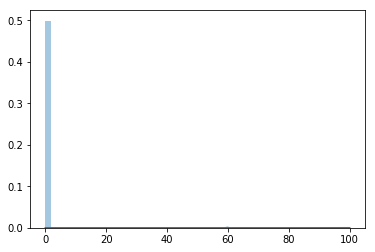

In [14]:
sns.distplot(list(df_purchases.express_points_received.values))

In [15]:
df_purchases.express_points_received[df_purchases.express_points_received > 0].value_counts()

60.0     103
20.0      53
40.0      28
100.0     15
30.0      13
15.0       9
5.0        6
Name: express_points_received, dtype: int64

Не так много значений отличных от 0

### Распределение regular_points_spent

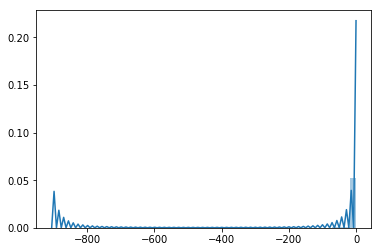

In [16]:
sns.distplot(list(df_purchases.regular_points_spent.values))

### Распределение express_points_spent

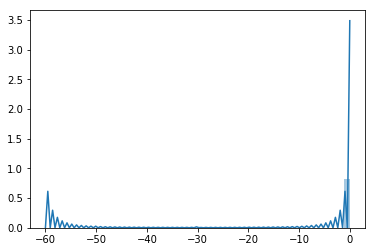

In [17]:
sns.distplot(list(df_purchases.express_points_spent.values))

### Распределение trn_sum_from_iss

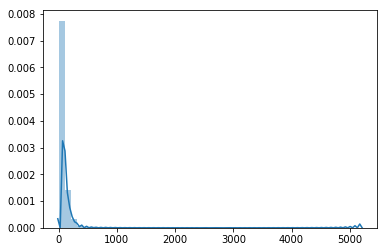

In [18]:
sns.distplot(list(df_purchases.trn_sum_from_iss.values))

In [19]:
# признаки трат и сбора экспрес и регулряный баллов по каждой транзакции в прошлом месяце
# средняя, max, min u std цена покупок
temp = last_month.groupby(['client_id','transaction_id']).regular_points_received.mean().rename(
    'last_reg_rec').groupby('client_id')
df_features = df_features.join(make_feats(temp,df_features.index,logging=False))
print("Add feature last_reg_rec")

# средняя, max, min u std цена покупок
temp = last_month.groupby(['client_id','transaction_id']).express_points_received.mean().rename(
    'last_exp_rec').groupby('client_id')
df_features = df_features.join(make_feats(temp,df_features.index,logging=False))
print("Add feature last_exp_rec_")

# средняя, max, min u std цена покупок
temp = last_month.groupby(['client_id','transaction_id']).regular_points_spent.mean().rename(
    'last_reg_spent').groupby('client_id')
df_features = df_features.join(make_feats(temp,df_features.index,logging=False))
print("Add feature last_reg_spent")

# средняя, max, min u std цена покупок
temp = last_month.groupby(['client_id','transaction_id']).express_points_spent.mean().rename(
    'last_exp_spent').groupby('client_id')
df_features = df_features.join(make_feats(temp,df_features.index,logging=False))
print("Add feature last_exp_spent")

Add feature last_reg_rec
Add feature last_exp_rec_
Add feature last_reg_spent
Add feature last_exp_spent


In [20]:
# признаки трат и сбора экспрес и регулряный баллов по каждой транзакции
# средняя, max, min u std цена покупок
temp = df_purchases.groupby(['client_id','transaction_id']).regular_points_received.mean().rename('reg_rec').groupby('client_id')
df_features = df_features.join(make_feats(temp,df_features.index,logging=False))
print("Add feature reg_rec X4")

# средняя, max, min u std цена покупок
temp = df_purchases.groupby(['client_id','transaction_id']).express_points_received.mean().rename('exp_rec').groupby('client_id')
df_features = df_features.join(make_feats(temp,df_features.index,logging=False))
print("Add feature exp_rec X4")

# средняя, max, min u std цена покупок
temp = df_purchases.groupby(['client_id','transaction_id']).regular_points_spent.mean().rename('reg_spent').groupby('client_id')
df_features = df_features.join(make_feats(temp,df_features.index,logging=False))
print("Add feature reg_spent X4")

# средняя, max, min u std цена покупок
temp = df_purchases.groupby(['client_id','transaction_id']).express_points_spent.mean().rename('exp_spent').groupby('client_id')
df_features = df_features.join(make_feats(temp,df_features.index,logging=False))
print("Add feature exp_spent X4")

Add feature reg_rec X4
Add feature exp_rec X4
Add feature reg_spent X4
Add feature exp_spent X4


In [21]:
make_feats(temp,df_features.index,logging=False)

,exp_spent,exp_spent_max,exp_spent_min,exp_spent_std
client_id,,,,
000012768d,0.0,0.0,0.0,0.0
000036f903,0.0,0.0,0.0,0.0
000048b7a6,0.0,0.0,0.0,0.0
000073194a,0.0,0.0,0.0,0.0
00007c7133,0.0,0.0,0.0,0.0
00007f9014,0.0,0.0,0.0,0.0
0000a90cf7,0.0,0.0,0.0,0.0
0000b59cec,0.0,0.0,0.0,0.0
0000bb4e4e,-4.0,0.0,-30.0,11.0


In [22]:
df_features.shape

(400162, 99)

In [23]:
df_features.head()

,gender_M,gender_F,gender_U,age,first_issue_time,first_redeem_time,issue_redeem_delay,count_all_purschases,count_all_stores,purch_sum_,...,exp_rec_min,exp_rec_std,reg_spent,reg_spent_max,reg_spent_min,reg_spent_std,exp_spent,exp_spent_max,exp_spent_min,exp_spent_std
client_id,,,,,,,,,,,,,,,,,,,,,
000012768d,0,0,1,45,1.501948e+09,1.515094e+09,1.314656e+07,52.0,3.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000036f903,0,1,0,72,1.491832e+09,1.492951e+09,1.118613e+06,162.0,5.0,5.0,...,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000048b7a6,0,1,0,68,1.544881e+09,-9.223372e+09,-1.076825e+10,56.0,2.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000073194a,0,1,0,60,1.495544e+09,1.511522e+09,1.597811e+07,82.0,1.0,6.0,...,0.0,0.0,-5.0,0.0,-96.0,23.0,0.0,0.0,0.0,0.0
00007c7133,0,0,1,67,1.495470e+09,1.546277e+09,5.080682e+07,83.0,2.0,6.0,...,0.0,0.0,-21.0,0.0,-240.0,72.0,0.0,0.0,0.0,0.0


### Feature selection

In [26]:
indices_train = df_train.index
indices_test = df_test.index
indices_learn, indices_valid = train_test_split(df_train.index, test_size=0.3, random_state=123)

model=LGBMClassifier()
X_train=df_features.loc[indices_learn, :].fillna(0).values
treatment_train=df_train.loc[indices_learn, 'treatment_flg'].values
target_train=df_train.loc[indices_learn, 'target'].values
X_test=df_features.loc[indices_valid, :].fillna(0).values

# model, X_train, treatment_train, target_train, X_test = 
X_treatment, y_treatment = X_train[treatment_train == 1, :], target_train[treatment_train == 1]
X_control, y_control = X_train[treatment_train == 0, :], target_train[treatment_train == 0]
model_treatment = clone(model).fit(X_treatment, y_treatment)
model_control = clone(model).fit(X_control, y_control)

In [27]:
eli5.explain_weights(model_control, feature_names = list(df_features.columns))

Weight,Feature
0.3969,issue_redeem_delay
0.1841,first_redeem_time
0.1106,age
0.0943,first_issue_time
0.0748,first_redeem_day
0.0501,first_issue_day
0.0178,first_issue_month
0.0164,first_redeem_month
0.0078,gender_M
0.0061,gender_U


In [30]:
feat_imp_c = model_treatment.feature_importances_
feat_imp_tr = model_control.feature_importances_

feat_names = df_features.columns

feats_dict_c = dict(zip(df_features.columns, feat_imp_c))
feats_dict_tr = dict(zip(df_features.columns, feat_imp_tr))

In [31]:
sort_feats_dict_c = dict(OrderedDict(sorted(feats_dict_c.items(), key = itemgetter(1), reverse = True)))
sort_feats_dict_tr = dict(OrderedDict(sorted(feats_dict_tr.items(), key = itemgetter(1), reverse = True)))

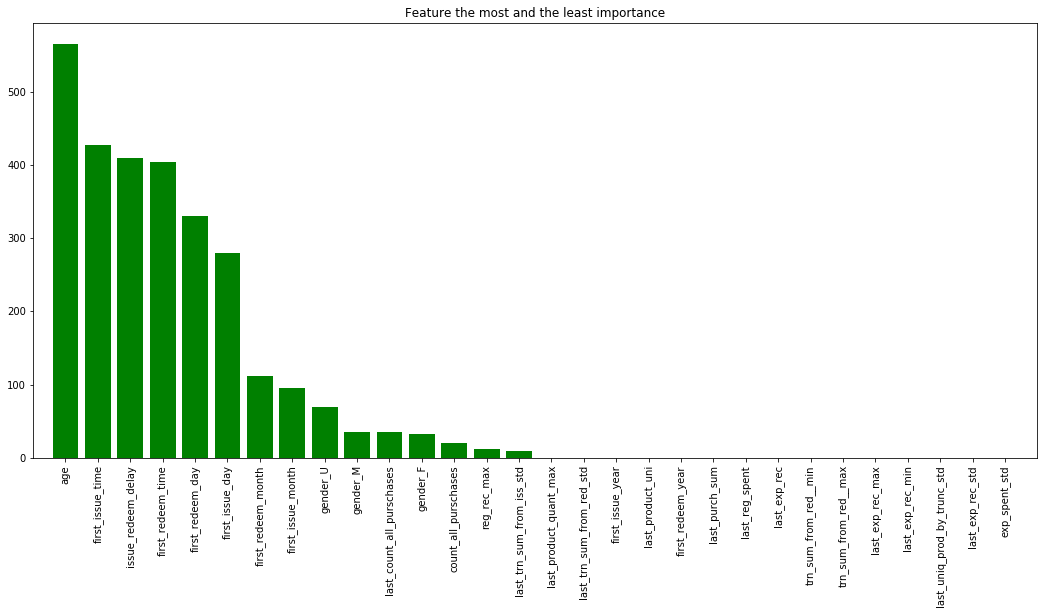

In [32]:
feat_names = df_features.columns
indices_c = np.concatenate([np.argsort(feat_imp_c)[::-1][:15],np.argsort(feat_imp_c)[::-1][-15:]])

plt.figure(figsize=(18,8))
plt.title("Feature the most and the least importance")
plt.bar(range(len(indices_c)), feat_imp_c[indices_c], color="g", align="center")
plt.xticks(range(len(indices_c)), feat_names[indices_c], rotation='vertical')
plt.xlim([-1, len(indices_c)])
plt.show()

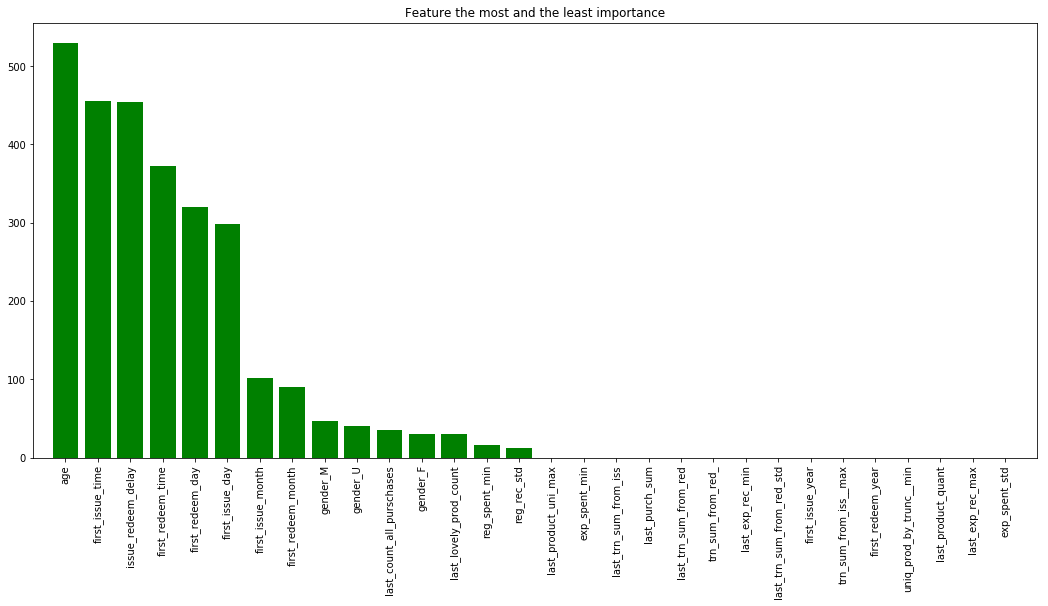

In [33]:
indices_tr = np.concatenate([np.argsort(feat_imp_tr)[::-1][:15],np.argsort(feat_imp_tr)[::-1][-15:]])

plt.figure(figsize=(18,8))
plt.title("Feature the most and the least importance")
plt.bar(range(len(indices_tr)), feat_imp_tr[indices_tr], color="g", align="center")
plt.xticks(range(len(indices_tr)), feat_names[indices_tr], rotation='vertical')
plt.xlim([-1, len(indices_tr)])
plt.show()

In [34]:
list_imp_feats = set([k for k, v in feats_dict_tr.items() if v!=0 ] + [k for k, v in feats_dict_c.items() if v!=0 ])

### Важные фичи

In [35]:
print(list_imp_feats)

{'trn_sum_from_red__std', 'last_lovely_prod_count', 'last_trn_sum_from_iss_min', 'last_purch_sum_std', 'product_quant_', 'first_redeem_day', 'first_redeem_month', 'last_reg_spent_min', 'product_uni__min', 'first_issue_day', 'age', 'purch_sum__min', 'last_reg_spent', 'last_trn_sum_from_iss_std', 'first_issue_month', 'last_trn_sum_from_iss', 'uniq_prod_by_trunc__min', 'trn_sum_from_iss__max', 'trn_sum_from_iss__std', 'last_product_quant', 'count_all_stores', 'first_redeem_time', 'last_uniq_prod_by_trunc', 'first_issue_time', 'reg_spent_std', 'uniq_prod_by_trunc__std', 'last_trn_sum_from_red_min', 'product_uni__std', 'purch_sum__max', 'last_uniq_prod_by_trunc_std', 'last_count_all_purschases', 'last_count_all_stores', 'exp_spent_min', 'reg_rec_max', 'trn_sum_from_red__min', 'reg_rec_std', 'last_reg_rec_std', 'gender_F', 'count_all_purschases', 'last_uniq_prod_by_trunc_max', 'trn_sum_from_red_', 'purch_sum_', 'last_product_uni', 'last_trn_sum_from_red', 'last_product_quant_max', 'last_purc

In [36]:
group_analisys(df_features[list_imp_feats], model=LGBMClassifier(),print_score=True,save_model=True,
               make_sibmition=True,filename='submission')

Validation score: 0.04616894266694871
